In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [7]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [8]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [9]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [10]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [11]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [12]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [13]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [15]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [17]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Define loss function & optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [19]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04045902  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.07559647  accuracy:  85.825%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.37198648  accuracy:  88.722%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01985848  accuracy:  90.554%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00678484  accuracy:  91.677%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00181786  accuracy:  92.508%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.46452770  accuracy:  93.124%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.01664556  accuracy:  93.600%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00718968  accuracy:  94.022%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.02756804  accuracy:  94.318%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.02209568  accuracy:  97.700%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.05276305  accuracy:  97.792%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00120053  accuracy:  97.850%
epoch:  1  b

## Plot the loss and accuracy comparisons

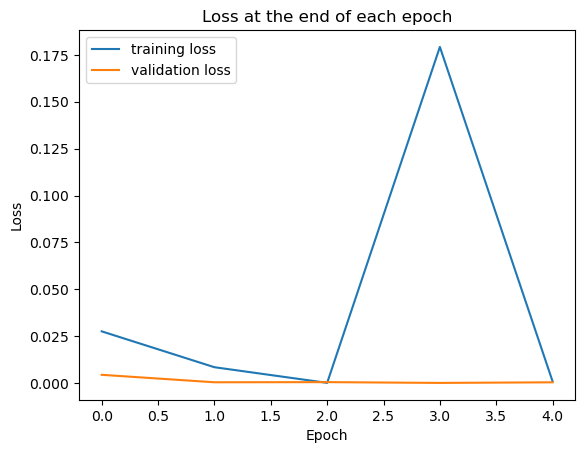

In [20]:
plt.plot([x.item() for x in train_losses], label='training loss')
plt.plot([x.item() for x in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
test_losses

[tensor(0.0044),
 tensor(0.0004),
 tensor(0.0005),
 tensor(6.9462e-05),
 tensor(0.0004)]

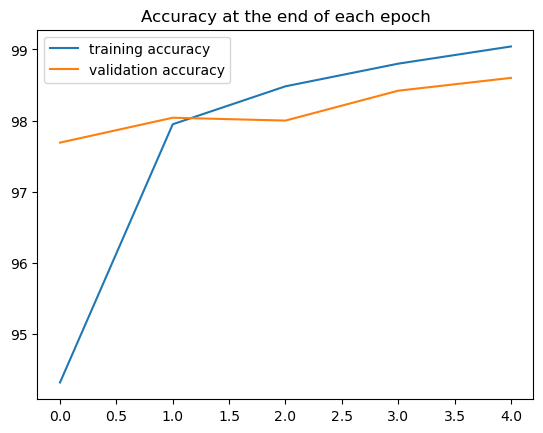

In [22]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [23]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [24]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9860/10000 =  98.600%


## Display the confusion matrix

In [25]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 968    0    0    0    0    2    3    0    3    0]
 [   0 1128    0    0    0    0    1    3    0    2]
 [   3    1 1024    0    1    0    1   12    3    2]
 [   0    1    3 1000    0   15    0    0    3    0]
 [   0    0    1    0  973    0    1    0    0    2]
 [   1    1    0    2    0  863    1    0    0    4]
 [   4    4    0    0    2    5  949    0    1    1]
 [   1    0    1    5    0    1    0 1008    1    3]
 [   3    0    3    3    1    2    2    2  963   11]
 [   0    0    0    0    5    4    0    3    0  984]]


## Examine the misses


In [26]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

140

In [27]:
# Display the first 10 index positions
misses[:10]

array([  18,  184,  235,  247,  320,  340,  412,  445,  448,  460])

In [28]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [  18  184  235  247  320  340  412  445  448  460  495  557]
Label: [   3    8    9    4    9    5    5    6    9    5    8    7]
Guess: [   8    3    8    2    8    3    3    0    8    9    0    2]


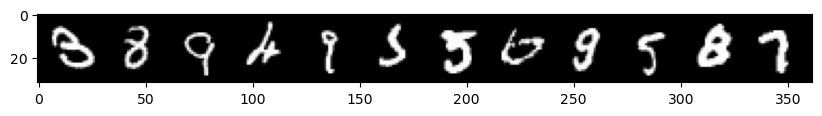

In [29]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model


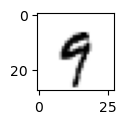

In [30]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [ ]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())